In [43]:
# Define imports and set global variables.

import numpy as np
import torch
import os.path as osp
from easydict import EasyDict
import matplotlib.pyplot as plt
from vis_utils import plot_detections, plot_rgb
from bbox3d_utils import masks_to_boxes, BatchBBox3D, get_transforms_from_rotmats_and_translations, quaternions_to_rotmats

# The dataset root path.
DATASET_ROOT_DIR = '/Users/msieb/Downloads/eccv_dataset_2'
# From what split to visualize.
SPLIT_FOLDER = 'train'
# The sample index to visualize.
SAMPLE_INDEX = 0


In [44]:

data_path = osp.join(DATASET_ROOT_DIR, SPLIT_FOLDER, '{:05d}'.format(SAMPLE_INDEX))
data = np.load(osp.join(data_path, 'data.npz'))
segm = np.load(osp.join(data_path, 'annotation/segm.npz'))
bbox3d = np.load(osp.join(data_path, 'annotation/bbox3d.npz')) # quaternion convention is (w, x, y, z)

depth = data['depth'] # shape(H, W)
intrinsic = data['intrinsic'] # shape(3, 3)
normals = data['normals'] # shape(3, H, W)

rgb = data['rgb'] # shape(3, H, W)
mask_occ = segm['masks'] # shape(N_objects, H, W)
mask_full = segm['masks_amodal'] # shape(N_objects, H, W)

### Visualize the data
We provide both 2D visualizations (rgb, masks, depth, normals) & 3D visualizations if you scroll further down (point cloud, 3D bounding boxes).

### 2D visualizations

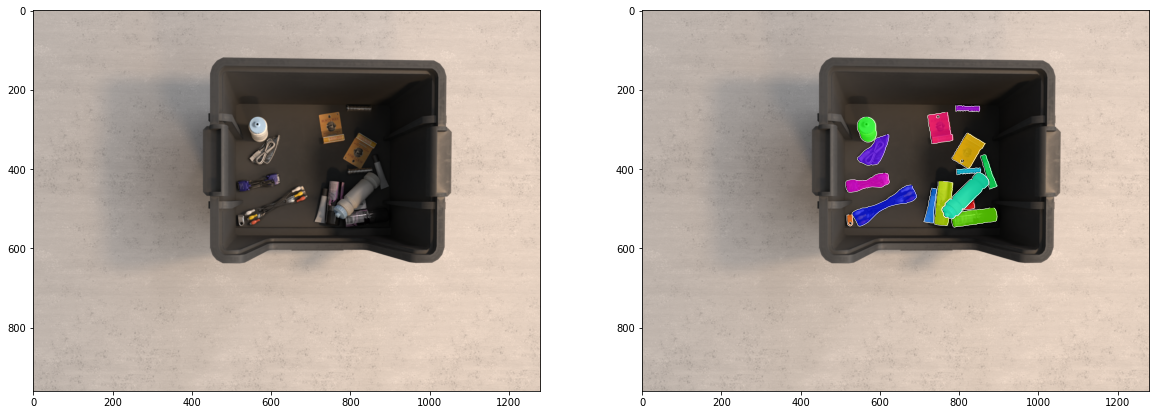

In [45]:
# RGB + masks
boxes = masks_to_boxes(torch.from_numpy(mask_full)) # use amodal masks for boxes
plot_detections(torch.from_numpy(rgb), torch.from_numpy(mask_occ), boxes, show_boxes=False, show_masks=True)

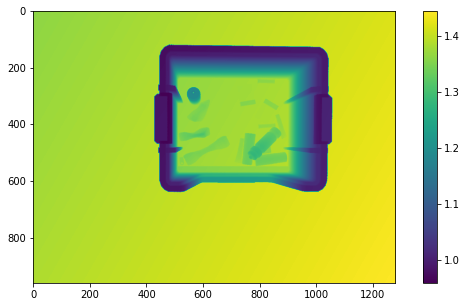

In [38]:
# Depth
plt.figure(figsize=(10, 5))
plt.imshow(depth)
plt.colorbar(orientation='vertical')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


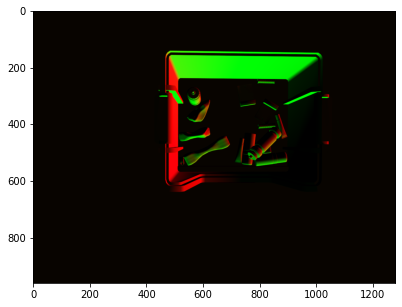

In [39]:
# Normals
plt.figure(figsize=(10, 5))
plt.imshow(normals.transpose(1, 2, 0))

### 3D visualizations

In [24]:
from scene_builder import SceneBuilder
from bbox3d_utils import depth2cloud

# Initialize the scene builder
builder = SceneBuilder.from_point_map(
    depth2cloud(torch.from_numpy(depth).float(), torch.from_numpy(intrinsic).float(), rgb.shape[-2], rgb.shape[-1])[0], torch.from_numpy(rgb).float(), flip_xz=True, size=2e-3, render_size=(480, 320)
)


/usr/local/lib/python3.9/site-packages/pythreejs/traits.py:203: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '
/usr/local/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(aspect=1.5, fov=90.0, position=(-0.0004832812961675141, 0.6884695243338007, …

In [36]:
# Add the predicted 3D bounding boxes (they will appear in the original SceneBuilder visualization above)
dimensions = torch.from_numpy(bbox3d['dimensions'])
translations = torch.from_numpy(bbox3d['centers'])
poses = get_transforms_from_rotmats_and_translations(rotmats=quaternions_to_rotmats(torch.from_numpy(bbox3d["orientations"])), translations=translations)
valids = torch.ones(dimensions.shape[0], device=dimensions.device, dtype=torch.bool)
boxes = BatchBBox3D(dimensions=dimensions, poses=poses, valids=valids)

builder.add_bbox3d_batch(boxes)

/usr/local/lib/python3.9/site-packages/pythreejs/traits.py:203: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '
